## Parameters

In [111]:
record_number = 101
model_structure = [2, 7, 5]
n_epochs = 10
batch_size = 2

## Importing Data

In [112]:
import pandas as pd
import numpy as np

df = pd.read_csv("kaggle.csv")
df = df[df['record'] == record_number]
df = df[["record", "type", "0_qrs_interval", "0_pre-RR", "0_post-RR"]]
df["0_rr_interval"] = df["0_post-RR"] - df["0_pre-RR"]
df.dropna(inplace=True)
df['type'].unique()

array(['N', 'Q', 'SVEB'], dtype=object)

## Making outputs

In [113]:
df['type'] = df["type"].map({
    "N": [1, 0, 0, 0, 0],
    "Q": [0, 1, 0, 0, 0],
    "SVEB": [0, 0, 1, 0, 0],
    "VEB": [0, 0, 0, 1, 0],
    "F": [0, 0, 0, 0, 1]
})

## Making x, y

In [114]:
x = df[["0_rr_interval" ,"0_qrs_interval"]]
y = np.array(df["type"].tolist())

In [115]:
x = (x - x.mean()) / x.std()

## Splitting data for training and testing

In [116]:
from sklearn.model_selection import train_test_split
import torch

x = torch.from_numpy(x.values).float()
y = torch.from_numpy(y).float()

x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.7, random_state=1
)

In [117]:
x_train, y_train

(tensor([[-0.3610, -0.5009],
         [ 0.1225,  1.4478],
         [-0.2731,  1.4478],
         ...,
         [-0.3170, -0.2843],
         [ 0.0346, -0.5009],
         [-0.7565, -0.0678]]),
 tensor([[1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         ...,
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]]))

## Arrhythmia Classifier

In [118]:
import torch.nn as nn


class Arrhythmia_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(model_structure[0], model_structure[1])
        self.act = nn.ReLU()
        self.output = nn.Linear(model_structure[1], model_structure[2])

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x


model = Arrhythmia_classifier()
model

Arrhythmia_classifier(
  (hidden): Linear(in_features=2, out_features=7, bias=True)
  (act): ReLU()
  (output): Linear(in_features=7, out_features=5, bias=True)
)

In [119]:
import torch.optim as optim
import numpy as np
import random

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)
random.seed(10)

In [120]:
import torch
import tqdm
import copy

batches_per_epoch = len(x_train) // batch_size

best_acc = -np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = x_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            #  TODO remove error here

            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(x_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")

model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 652/652 [00:02<00:00, 285.18batch/s, acc=1, loss=0.0011]  


Epoch 0 validation: Cross-entropy=0.05099770799279213, Accuracy=0.9946428537368774


Epoch 1: 100%|██████████| 652/652 [00:02<00:00, 281.17batch/s, acc=1, loss=0.00035] 


Epoch 1 validation: Cross-entropy=0.036047887057065964, Accuracy=0.9946428537368774


Epoch 2: 100%|██████████| 652/652 [00:02<00:00, 288.99batch/s, acc=1, loss=0.000132]


Epoch 2 validation: Cross-entropy=0.03995241969823837, Accuracy=0.9946428537368774


Epoch 3: 100%|██████████| 652/652 [00:02<00:00, 295.67batch/s, acc=1, loss=0.000107]


Epoch 3 validation: Cross-entropy=0.04638935253024101, Accuracy=0.9928571581840515


Epoch 4: 100%|██████████| 652/652 [00:02<00:00, 280.01batch/s, acc=1, loss=1.23e-5] 


Epoch 4 validation: Cross-entropy=0.05660954490303993, Accuracy=0.9946428537368774


Epoch 5: 100%|██████████| 652/652 [00:02<00:00, 307.10batch/s, acc=1, loss=2.52e-5] 


Epoch 5 validation: Cross-entropy=0.06431945413351059, Accuracy=0.9928571581840515


Epoch 6: 100%|██████████| 652/652 [00:02<00:00, 304.46batch/s, acc=1, loss=1.17e-5] 


Epoch 6 validation: Cross-entropy=0.05977415293455124, Accuracy=0.9928571581840515


Epoch 7: 100%|██████████| 652/652 [00:02<00:00, 296.81batch/s, acc=1, loss=8.82e-6] 


Epoch 7 validation: Cross-entropy=0.05754564702510834, Accuracy=0.9946428537368774


Epoch 8: 100%|██████████| 652/652 [00:02<00:00, 305.02batch/s, acc=1, loss=1.31e-5] 


Epoch 8 validation: Cross-entropy=0.056547779589891434, Accuracy=0.9928571581840515


Epoch 9: 100%|██████████| 652/652 [00:02<00:00, 301.17batch/s, acc=1, loss=5.36e-6] 

Epoch 9 validation: Cross-entropy=0.053833138197660446, Accuracy=0.9946428537368774


<All keys matched successfully>

## Plotting Cross entropy and accuracy

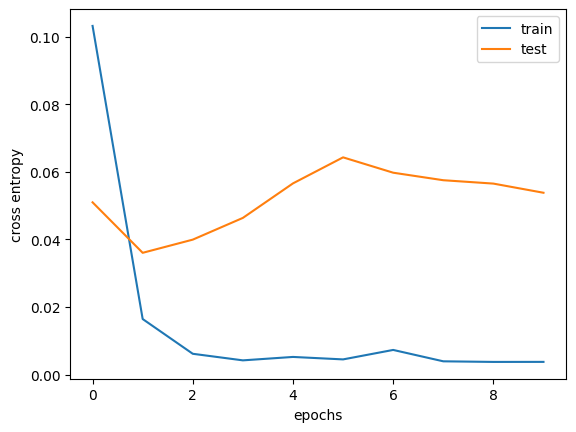

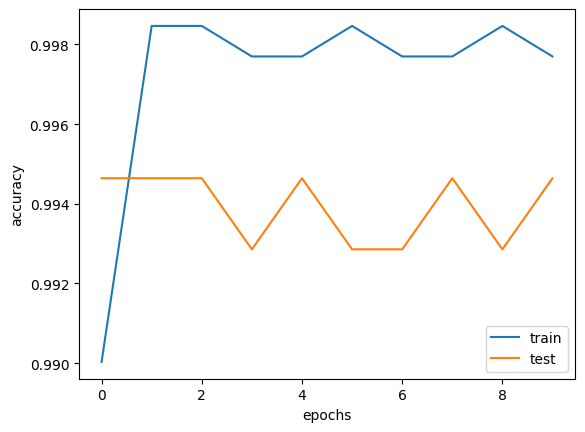

In [121]:
import matplotlib.pyplot as plt

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()